In [110]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from importlib.machinery import SourceFileLoader

# imports the module from the given path
helpers_path = "../helper_functions.py"
helpers = SourceFileLoader("gfg",helpers_path).load_module()

In [3]:
df = pd.read_csv("BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
# Splitting the data so we can see later how our predictions compared to real life

bitcoin_df = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})



In [6]:
split_size = int(0.8 * len(bitcoin_df))
timesteps = bitcoin_df.index.to_numpy()
prices = bitcoin_df["Price"].to_numpy()

X_train, y_train  = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2487, 622, 2487, 622)

In [7]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)


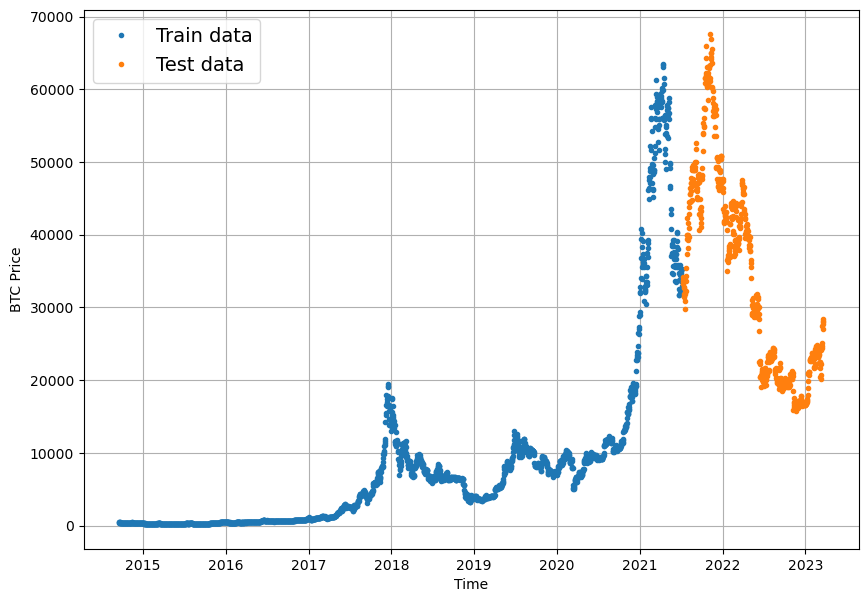

In [8]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Naive Model

naive formula = $$\hat{y}_{t} = y_{t-1}$$

In [9]:
y_test[:10]

array([33798.011719, 33520.519531, 34240.1875  , 33155.847656,
       32702.025391, 32822.347656, 31780.730469, 31421.539063,
       31533.068359, 31796.810547])

In [10]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([33798.011719, 33520.519531, 34240.1875  , 33155.847656,
        32702.025391, 32822.347656, 31780.730469, 31421.539063,
        31533.068359, 31796.810547]),
 array([22163.949219, 24197.533203, 24746.074219, 24375.960938,
        25052.789063, 27423.929688, 26965.878906, 28038.675781,
        27767.236328, 28175.816406]))

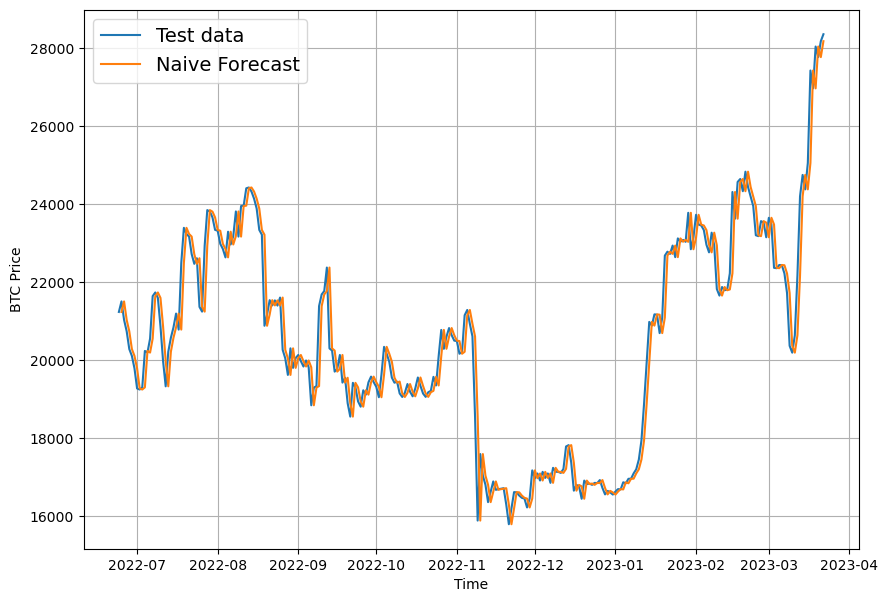

In [11]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

In [12]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [13]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

# Formatting Data

In [14]:
HORIZON = 1
WINDOW_SIZE = 7

In [15]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [16]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [17]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [18]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3102, 3102)

In [19]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [20]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328]
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [28175.816406]
Window: [24375.960938 25052.789063 27423.929688 26965.878906 28038.675781
 27767.236328 28175.816406] -> Label: [28354.666016]


In [21]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of winodws and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2481, 621, 2481, 621)

In [22]:
predict_windows, predict_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [23]:
train_windows[:4], train_labels[:4], test_windows[:4], test_labels[:4]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989]]),
 array([[34668.546875, 35287.78125 , 33746.003906, 34235.195313,
         33855.328125, 32877.371094, 33798.011719],
        [35287.78125 , 33746.003906, 34235.195313, 33855.328125,
         32877.371094, 33798.011719, 33520.519531],
        [33746.003906, 34235.195313, 33855.328125, 32877.371094,
         33798.011719, 33520.519531, 34240.1875  ],
        [34235.195313, 33855.328125, 32877.371094, 33798.011719,
         33520.519531, 34240.1875  , 33155.847656]]),
 array([[33520.519531],
  

In [24]:
train_labels[:-HORIZON-1]

array([[  423.204987],
       [  411.574005],
       [  404.424988],
       ...,
       [33746.003906],
       [34235.195313],
       [33855.328125]])

In [25]:
y_train[WINDOW_SIZE:]

array([  423.204987,   411.574005,   404.424988, ..., 34235.195313,
       33855.328125, 32877.371094])

In [26]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2481, 621, 2481, 621)

# Modeling Experiments


In [27]:
import os
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, 
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

In [28]:
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear"),
], name="model_1_dense"
)

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"]
                )

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data = (test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]
            )

Epoch 1/100
20/20 [==============================] - 3s 97ms/step - loss: 1852.8406 - mae: 1852.8406 - mse: 16518314.0000 - val_loss: 3707.5938 - val_mae: 3707.5938 - val_mse: 19789292.0000
Epoch 2/100
20/20 [==============================] - 1s 53ms/step - loss: 570.3339 - mae: 570.3339 - mse: 1757954.7500 - val_loss: 2113.6611 - val_mae: 2113.6611 - val_mse: 7436755.5000
Epoch 3/100
20/20 [==============================] - 1s 50ms/step - loss: 450.3375 - mae: 450.3375 - mse: 1167506.3750 - val_loss: 1465.1293 - val_mae: 1465.1293 - val_mse: 4068705.2500
Epoch 4/100
20/20 [==============================] - 1s 43ms/step - loss: 406.5938 - mae: 406.5938 - mse: 983264.2500 - val_loss: 1279.2374 - val_mae: 1279.2374 - val_mse: 3315203.2500
Epoch 5/100
20/20 [==============================] - 1s 51ms/step - loss: 397.0490 - mae: 397.0490 - mse: 939349.7500 - val_loss: 1236.5725 - val_mae: 1236.5725 - val_mse: 3091886.5000
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - l

KeyboardInterrupt: 

In [ ]:
model_1.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 895us/step - loss: 893.5045 - mae: 893.5045 - mse: 1702920.7500


[893.5044555664062, 893.5044555664062, 1702920.75]

In [ ]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")

In [ ]:
model_1.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 895us/step - loss: 825.1354 - mae: 825.1354 - mse: 1541033.2500


[825.1354370117188, 825.1354370117188, 1541033.25]

In [ ]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

model_1_preds = make_preds(model_1, test_windows) 
len(model_1_preds), model_1_preds[:10]

20/20 [==============================] - 0s 790us/step


(621,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([33502.086, 33520.066, 34130.656, 33302.555, 32741.098, 32689.678,
        31876.568, 31335.05 , 31359.412, 31687.89 ], dtype=float32)>)

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 825.13544,
 'mse': 1541033.4,
 'rmse': 1241.3837,
 'mape': 2.3888023,
 'mase': 1.0221322}

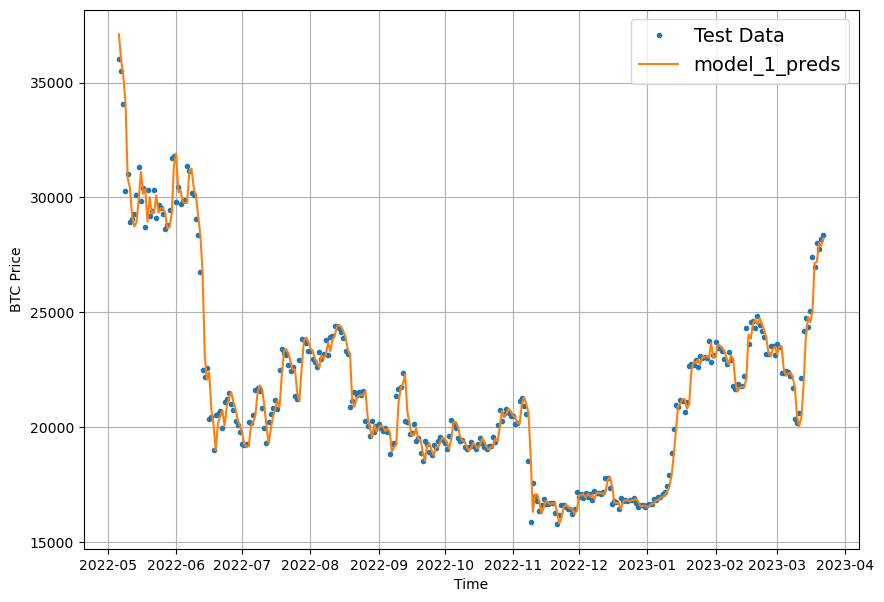

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset, 
                 format="-",
                 label="model_1_preds")

## Model 2 - Dense Model(window_size=30, horizon=1)

In [ ]:
WINDOW_SIZE = 30
HORIZON = 1

full_windows, full_labels = make_windows(x=prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,full_labels)

model_2 = tf.keras.models.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
    ], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
20/20 [==============================] - 1s 49ms/step - loss: 3064.9182 - mae: 3064.9182 - mse: 52457564.0000 - val_loss: 4710.4204 - val_mae: 4710.4204 - val_mse: 37273560.0000
Epoch 2/100
20/20 [==============================] - 1s 78ms/step - loss: 1029.3212 - mae: 1029.3212 - mse: 5279150.5000 - val_loss: 2892.9988 - val_mae: 2892.9988 - val_mse: 14488559.0000
Epoch 3/100
20/20 [==============================] - 1s 40ms/step - loss: 792.3527 - mae: 792.3527 - mse: 3347845.7500 - val_loss: 2091.4197 - val_mae: 2091.4197 - val_mse: 8220970.5000
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 621.6538 - mae: 621.6538 - mse: 2149828.5000 - val_loss: 2288.2615 - val_mae: 2288.2615 - val_mse: 8865572.0000
Epoch 5/100
20/20 [==============================] - 1s 57ms/step - loss: 583.6555 - mae: 583.6555 - mse: 1851340.6250 - val_loss: 1822.2437 - val_mae: 1822.2437 - val_mse: 6009789.5000
Epoch 6/100
20/20 [==============================] - 1s 38ms/ste

In [ ]:
model_2.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 921us/step - loss: 891.9243 - mae: 891.9243 - mse: 1741616.7500


[891.92431640625, 891.92431640625, 1741616.75]

In [ ]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 868us/step - loss: 891.9243 - mae: 891.9243 - mse: 1741616.7500


[891.92431640625, 891.92431640625, 1741616.75]

In [ ]:
model_2_preds = make_preds(model_2, test_windows)

20/20 [==============================] - 0s 789us/step


In [ ]:
model_2_results = eval_metrics.evaluate_preds(y_true=tf.squeeze(test_labels),
                                              y_pred=model_2_preds)
model_2_results

{'mae': 891.9243,
 'mse': 1741616.6,
 'rmse': 1319.7032,
 'mape': 2.578999,
 'mase': 1.1034961}

In [ ]:
model_1_results

{'mae': 825.13544,
 'mse': 1541033.4,
 'rmse': 1241.3837,
 'mape': 2.3888023,
 'mase': 1.0221322}

## Model 3 Dense Horizon=7 Windowsize = 30

In [29]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3073, 3073)

In [30]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2458, 615, 2458, 615)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
],name ="model_3_dense")

model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: mod

In [ ]:
model_3.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 789us/step - loss: 1798.5978


1798.5977783203125

In [ ]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 816us/step - loss: 1771.6344


1771.6343994140625

In [ ]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

20/20 [==============================] - 0s 737us/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[32783.664, 32418.979, 32252.611, 33135.93 , 32216.06 , 32177.707,
        31466.494],
       [33387.613, 33027.645, 32974.484, 32786.355, 33241.86 , 32943.38 ,
        31928.828],
       [34147.62 , 33732.383, 33841.633, 33853.133, 34668.133, 33634.793,
        32982.082],
       [33567.805, 33724.09 , 33220.418, 33784.758, 33126.9  , 32682.104,
        32691.482],
       [32561.299, 32669.756, 31951.547, 32086.324, 31276.537, 31180.094,
        31582.824]], dtype=float32)>

In [ ]:
model_3_results = helpers.evaluate_preds(y_true=tf.squeeze(test_labels),
                                              y_pred=model_3_preds)

model_3_results

{'mae': 1771.6344,
 'mse': 6563310.0,
 'rmse': 2020.8976,
 'mape': 5.2486124,
 'mase': 2.189025}

In [ ]:
model_2_results

{'mae': 891.9243,
 'mse': 1741616.6,
 'rmse': 1319.7032,
 'mape': 2.578999,
 'mase': 1.1034961}

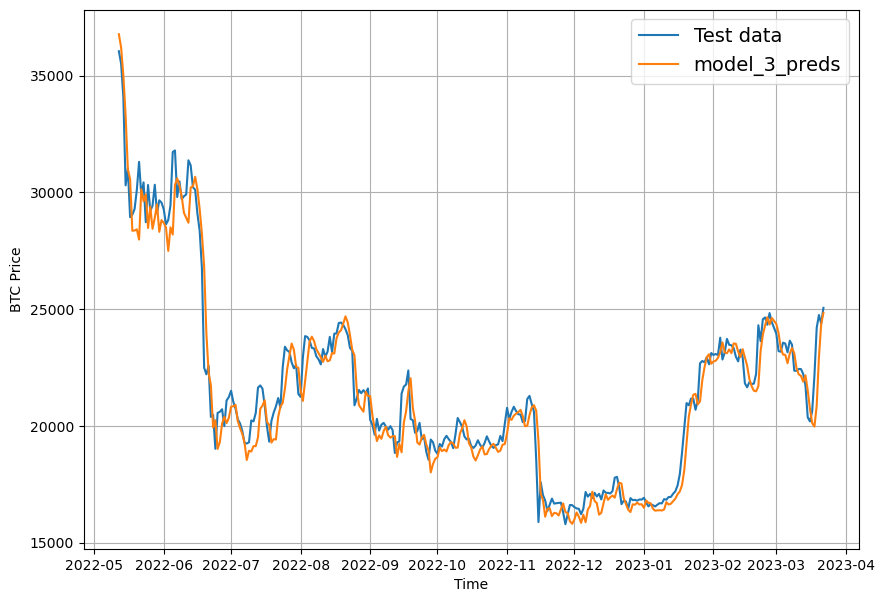

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 format="-",
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 start=offset,
                 format="-", 
                 label="model_3_preds")

## Model 4 : Conv1D Window=7 Horizon=1

In [31]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3102, 3102)

In [32]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3102, 3102)

In [33]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2481, 2481, 621, 621)

In [ ]:
train_windows[0].shape

(7,)

In [ ]:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

In [34]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [ ]:
print(f"Original shape: {x.shape}") # (WINDIW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 895us/step - loss: 855.4722


855.4722290039062

In [ ]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 895us/step - loss: 831.0320


831.031982421875

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

20/20 [==============================] - 0s 842us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33479.79 , 33478.043, 34036.863, 33316.086, 32716.69 , 32697.807,
       31871.068, 31344.596, 31354.562, 31629.945], dtype=float32)>

In [ ]:
model_4_preds = tf.squeeze(model_4_preds)
model_4_preds[:3]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([33479.79 , 33478.043, 34036.863], dtype=float32)>

In [ ]:
model_4_results = eval_metrics.evaluate_preds(y_true=tf.squeeze(test_labels),
                                              y_pred=model_4_preds)
model_4_results

{'mae': 831.032,
 'mse': 1553760.5,
 'rmse': 1246.4993,
 'mape': 2.4027424,
 'mase': 1.0294365}

## Model 5: LSTM Window=7 Horizon=1

In [ ]:
#uses same data as model 4
import logging
tf.get_logger().setLevel(logging.ERROR)


inputs = layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)]
)

Epoch 1/100
20/20 [==============================] - 4s 162ms/step - loss: 5791.4512 - val_loss: 15276.6152
Epoch 2/100
20/20 [==============================] - 3s 136ms/step - loss: 1833.6917 - val_loss: 2350.2126
Epoch 3/100
20/20 [==============================] - 3s 149ms/step - loss: 613.7363 - val_loss: 1647.1771
Epoch 4/100
20/20 [==============================] - 3s 137ms/step - loss: 482.0025 - val_loss: 1545.4785
Epoch 5/100
20/20 [==============================] - 3s 140ms/step - loss: 451.9539 - val_loss: 1525.8923
Epoch 6/100
20/20 [==============================] - 3s 149ms/step - loss: 448.4603 - val_loss: 1479.3812
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 444.5920 - val_loss: 1516.0287
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 446.1949 - val_loss: 1514.4407
Epoch 9/100
20/20 [==============================] - 3s 133ms/step - loss: 433.8210 - val_loss: 1430.0316
Epoch 10/100
20/20 [===========================

In [ ]:
model_5.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 890.5452


890.545166015625

In [ ]:
model_5 = tf.keras.models.load_model("model_experiments/model_5/")
model_5.evaluate(test_windows,test_labels)

20/20 [==============================] - 0s 1ms/step - loss: 868.5974


868.5973510742188

In [ ]:
model_5_preds = model_5.predict(test_windows)
model_5_preds = tf.squeeze(model_5_preds)
model_5_preds

20/20 [==============================] - 0s 974us/step


<tf.Tensor: shape=(621,), dtype=float32, numpy=
array([33384.824, 33404.387, 33910.695, 33416.484, 32844.902, 32713.127,
       31912.38 , 31368.973, 31301.455, 31502.566, 30949.117, 30036.01 ,
       31300.002, 32009.71 , 33155.56 , 34190.973, 35230.1  , 36942.72 ,
       38970.96 , 40110.54 , 40419.855, 41933.863, 41988.363, 40679.438,
       39572.61 , 38339.035, 38951.105, 40140.176, 42067.742, 44126.   ,
       44316.996, 45991.992, 46023.273, 45808.723, 44903.613, 46762.55 ,
       47120.3  , 47107.973, 46464.348, 45125.03 , 44622.664, 45797.027,
       48238.2  , 48994.246, 49515.24 , 49776.137, 48384.062, 48590.7  ,
       47339.125, 48253.754, 48693.973, 48750.402, 47609.91 , 47114.652,
       48126.74 , 48883.637, 49746.254, 50062.664, 51342.7  , 52411.2  ,
       48674.285, 46513.438, 45932.84 , 44635.613, 44606.473, 45417.395,
       45063.168, 46371.64 , 47739.418, 47933.26 , 47607.086, 48089.62 ,
       47512.848, 44114.918, 41268.168, 42187.   , 43676.363, 43038.957,
   

In [ ]:
model_5_results = eval_metrics.evaluate_preds(y_true=tf.squeeze(test_labels),
                                              y_pred=model_5_preds)
model_5_results

{'mae': 868.5972,
 'mse': 1654478.4,
 'rmse': 1286.2653,
 'mape': 2.5151768,
 'mase': 1.0759703}

## Model 6 - Multivariate Data

In [35]:
black_reward_1 = 50 #Jan 3 2009 not in our data
block_reward_2 = 25 #Nov 8, 2012
block_reward_3 = 12.5 # July 9, 2016
block_reward_4 =6.25 #May 18, 2020


block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

block_reward_2_days = (block_reward_3_datetime - bitcoin_df.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_df.index[0]).days



In [36]:
bitcoin_block_df = bitcoin_df.copy()
bitcoin_block_df["block_reward"] = None
bitcoin_block_df.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_block_df.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_block_df.iloc[block_reward_3_days:, -1] = block_reward_4

In [37]:
bitcoin_block_df.iloc[block_reward_2_days-2:block_reward_2_days+3,-1]

Date
2016-07-07      25
2016-07-08      25
2016-07-09    12.5
2016-07-10    12.5
2016-07-11    12.5
Name: block_reward, dtype: object

In [38]:
bitcoin_block_df.iloc[block_reward_3_days-2:block_reward_3_days+3,-1]

Date
2020-05-16    12.5
2020-05-17    12.5
2020-05-18    6.25
2020-05-19    6.25
2020-05-20    6.25
Name: block_reward, dtype: object

In [39]:
bitcoin_block_df.tail()

,Price,block_reward
Date,,
2023-03-18,26965.878906,6.25
2023-03-19,28038.675781,6.25
2023-03-20,27767.236328,6.25
2023-03-21,28175.816406,6.25
2023-03-22,28354.666016,6.25


<AxesSubplot: xlabel='Date'>

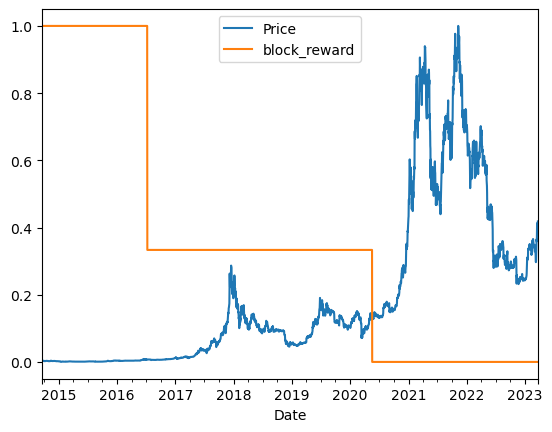

In [40]:
#scaling for univariate data
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_block_df[["Price", "block_reward"]]),
                                     columns=bitcoin_block_df.columns,
                                     index=bitcoin_block_df.index)
scaled_price_block_df.plot()

In [41]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_block_windowed_df = bitcoin_block_df.copy()
for i in range(WINDOW_SIZE):
    bitcoin_block_windowed_df[f"Price+{i+1}"] = bitcoin_block_windowed_df["Price"].shift(periods=i+1)
    
bitcoin_block_windowed_df.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [42]:
X = bitcoin_block_windowed_df.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_block_windowed_df.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [43]:
y.head()

Date
2014-09-24    423.204987
2014-09-25    411.574005
2014-09-26    404.424988
2014-09-27    399.519989
2014-09-28    377.181000
Name: Price, dtype: float32

In [44]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2481, 2481, 621, 621)

In [45]:
X_test

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2021-07-10,6.25,33798.011719,32877.371094,33855.328125,34235.195312,33746.003906,35287.781250,34668.546875
2021-07-11,6.25,33520.519531,33798.011719,32877.371094,33855.328125,34235.195312,33746.003906,35287.781250
2021-07-12,6.25,34240.187500,33520.519531,33798.011719,32877.371094,33855.328125,34235.195312,33746.003906
2021-07-13,6.25,33155.847656,34240.187500,33520.519531,33798.011719,32877.371094,33855.328125,34235.195312
2021-07-14,6.25,32702.025391,33155.847656,34240.187500,33520.519531,33798.011719,32877.371094,33855.328125
...,...,...,...,...,...,...,...,...
2023-03-18,6.25,27423.929688,25052.789062,24375.960938,24746.074219,24197.533203,22163.949219,20632.410156
2023-03-19,6.25,26965.878906,27423.929688,25052.789062,24375.960938,24746.074219,24197.533203,22163.949219
2023-03-20,6.25,28038.675781,26965.878906,27423.929688,25052.789062,24375.960938,24746.074219,24197.533203


In [46]:
y_test

Date
2021-07-10    33520.519531
2021-07-11    34240.187500
2021-07-12    33155.847656
2021-07-13    32702.025391
2021-07-14    32822.347656
                  ...     
2023-03-18    26965.878906
2023-03-19    28038.675781
2023-03-20    27767.236328
2023-03-21    28175.816406
2023-03-22    28354.666016
Name: Price, Length: 621, dtype: float32

In [47]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
20/20 [==============================] - 1s 42ms/step - loss: 2908.4404 - val_loss: 4805.7095
Epoch 2/100
20/20 [==============================] - 1s 48ms/step - loss: 766.3325 - val_loss: 1560.3306
Epoch 3/100
20/20 [==============================] - 1s 33ms/step - loss: 493.3461 - val_loss: 1533.9681
Epoch 4/100
20/20 [==============================] - 1s 34ms/step - loss: 474.3518 - val_loss: 1498.5652
Epoch 5/100
20/20 [==============================] - 1s 52ms/step - loss: 460.1052 - val_loss: 1456.8295
Epoch 6/100
20/20 [==============================] - 1s 37ms/step - loss: 443.4266 - val_loss: 1403.2577
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 434.0464 - val_loss: 1494.8474
Epoch 8/100
20/20 [==============================] - 1s 43ms/step - loss: 431.2174 - val_loss: 1349.1797
Epoch 9/100
20/20 [==============================] - 1s 55ms/step - loss: 413.6591 - val_loss: 1305.5623
Epoch 10/100
20/20 [==============================] - 1

KeyboardInterrupt: 

In [ ]:
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 947us/step - loss: 862.7001


862.7000732421875

In [ ]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test,y_test)

20/20 [==============================] - 0s 869us/step - loss: 822.9792


822.9791870117188

In [ ]:
model_6_preds = model_6.predict(X_test)
model_6_preds = tf.squeeze(model_6_preds)
model_6_preds[:10]

20/20 [==============================] - 0s 791us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33559.867, 33560.754, 34052.71 , 33318.016, 32701.088, 32752.39 ,
       31821.459, 31291.422, 31439.7  , 31673.498], dtype=float32)>

In [ ]:
model_6_results = eval_metrics.evaluate_preds(y_true=y_test,
                                              y_pred=model_6_preds)
model_6_results

{'mae': 822.9794,
 'mse': 1521362.4,
 'rmse': 1233.4352,
 'mape': 2.3785362,
 'mase': 1.0194614}

## Model 6-2 : Scaling the data

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.expand_dims(y , axis = 1))
print(y_scaled[:5])
y_scaled = np.squeeze(y_scaled)
print(y_scaled[:5])

[[0.00363714]
 [0.00346454]
 [0.00335845]
 [0.00328567]
 [0.00295417]]
[0.00363714 0.00346454 0.00335845 0.00328567 0.00295417]


In [49]:
split_size = int(len(X) * 0.8)
X_train, y_train = X_scaled[:split_size], y_scaled[:split_size]
X_test, y_test = X_scaled[split_size:], y_scaled[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2481, 2481, 621, 621)

In [50]:
tf.random.set_seed(42)

model_6_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate_scaled")

model_6_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6_2.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6_2.name)])

Epoch 1/100
20/20 [==============================] - 1s 44ms/step - loss: 0.0570 - val_loss: 0.0531
Epoch 2/100
20/20 [==============================] - 1s 65ms/step - loss: 0.0154 - val_loss: 0.0261
Epoch 3/100
20/20 [==============================] - 1s 43ms/step - loss: 0.0092 - val_loss: 0.0236
Epoch 4/100
 1/20 [>.............................] - ETA: 0s - loss: 0.0099

KeyboardInterrupt: 

In [ ]:
model_6_2_eval = model_6_2.evaluate(X_test,y_test)
scaler.inverse_transform([[model_6_2_eval]])

20/20 [==============================] - 0s 791us/step - loss: 0.0140


array([[1120.6180315]])

In [ ]:
model_6_2 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate_scaled")
model_6_2_eval = model_6_2.evaluate(X_test,y_test)
scaler.inverse_transform([[model_6_2_eval]])

20/20 [==============================] - 0s 817us/step - loss: 0.0125


array([[1023.46418102]])

## N-Beats Replication

replicating this paper: https://arxiv.org/pdf/1905.10437.pdf

###  Block Layer

In [51]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size:int,
                 theta_size:int,
                 horizon:int,
                 n_neurons:int,
                 n_layers:int,
                 **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        
        # Block contains stack of 4 connected Dense layers with relu activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        
        # Output is theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")
        
    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        
        #output
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast
        

In [52]:
HORIZON = 1
WINDOW = 7
bitcoin_nbeats_df = bitcoin_df.copy()
for i in range(WINDOW_SIZE):
  bitcoin_nbeats_df[f"Price+{i+1}"] = bitcoin_nbeats_df["Price"].shift(periods=i+1)
bitcoin_nbeats_df.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,377.181000,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [53]:
X = bitcoin_nbeats_df.dropna().drop("Price", axis=1)
y = bitcoin_nbeats_df.dropna()["Price"]

split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2481, 2481, 621, 621)

In [54]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [55]:
# SETTING HYPERPARAMETERS FOR N-BEATS-G VERSION
N_EPOCHS =  5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON #lookback
THETA_SIZE = INPUT_SIZE + HORIZON

In [56]:
%%time

#Creating Model

tf.random.set_seed(42)

#Nbeats block
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="NBeatsBlock_Initial")

#Stack input
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

#Initial Backcast and Forecast input
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name="subtract_00")

#Stacks for block layers
for i, _ in enumerate(range(N_STACKS-1)):
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name=f"NBeatsBlock_{i}"
                                 )(residuals)

    #double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
    
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

#early stopping and ReduceLROnPlateau 
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])

Epoch 1/5000
3/3 [==============================] - 12s 1s/step - loss: 61773.8203 - val_loss: 2941.0181 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 1s 448ms/step - loss: 19334.5000 - val_loss: 27132.6934 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 2s 519ms/step - loss: 6525.1211 - val_loss: 8159.8340 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 1s 461ms/step - loss: 4142.4028 - val_loss: 7400.3545 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 1s 458ms/step - loss: 1025.3956 - val_loss: 2070.3906 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 1s 364ms/step - loss: 1453.3385 - val_loss: 2140.0796 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 1s 450ms/step - loss: 1495.1187 - val_loss: 2335.4651 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 1s 420ms/step - loss: 2182.5337 - val_loss: 2367.3787 - lr: 0.0010
Epoch 9/5000
3/3 [=============================

KeyboardInterrupt: 

In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 74ms/step - loss: 865.4414


865.44140625

In [ ]:
model_7_preds = tf.squeeze(model_7.predict(test_dataset))
model_7_preds

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(621,), dtype=float32, numpy=
array([33702.863, 33709.49 , 34118.38 , 33697.41 , 32998.21 , 32946.26 ,
       32201.188, 31647.059, 31591.7  , 31803.418, 31298.648, 30343.701,
       31550.537, 32228.508, 33107.703, 34070.883, 35286.777, 37409.688,
       39233.02 , 40277.777, 40251.41 , 42249.105, 42046.42 , 40528.61 ,
       39547.617, 38582.63 , 39321.99 , 40585.25 , 42001.406, 44057.824,
       44071.688, 46431.27 , 45953.96 , 45911.61 , 44900.812, 46940.594,
       47355.36 , 47111.676, 46471.33 , 45131.08 , 45008.08 , 46256.742,
       48443.008, 48787.918, 49391.426, 49758.67 , 48296.68 , 48804.594,
       47818.375, 48603.12 , 49165.227, 48974.41 , 47841.348, 47326.566,
       48509.523, 49238.406, 49868.605, 50004.117, 51481.31 , 52646.367,
       48645.71 , 46542.867, 46225.04 , 44904.875, 44706.195, 45761.08 ,
       45470.625, 46590.15 , 47844.234, 47961.26 , 47520.164, 48108.4  ,
       47691.227, 44414.258, 41648.965, 42321.516, 43967.703, 43174.875,
   

In [ ]:
model_7_results = eval_metrics.evaluate_preds(y_true=y_test,
                                              y_pred=model_7_preds)
model_7_results

{'mae': 865.4414,
 'mse': 1667164.0,
 'rmse': 1291.187,
 'mape': 2.5077727,
 'mase': 1.0720611}

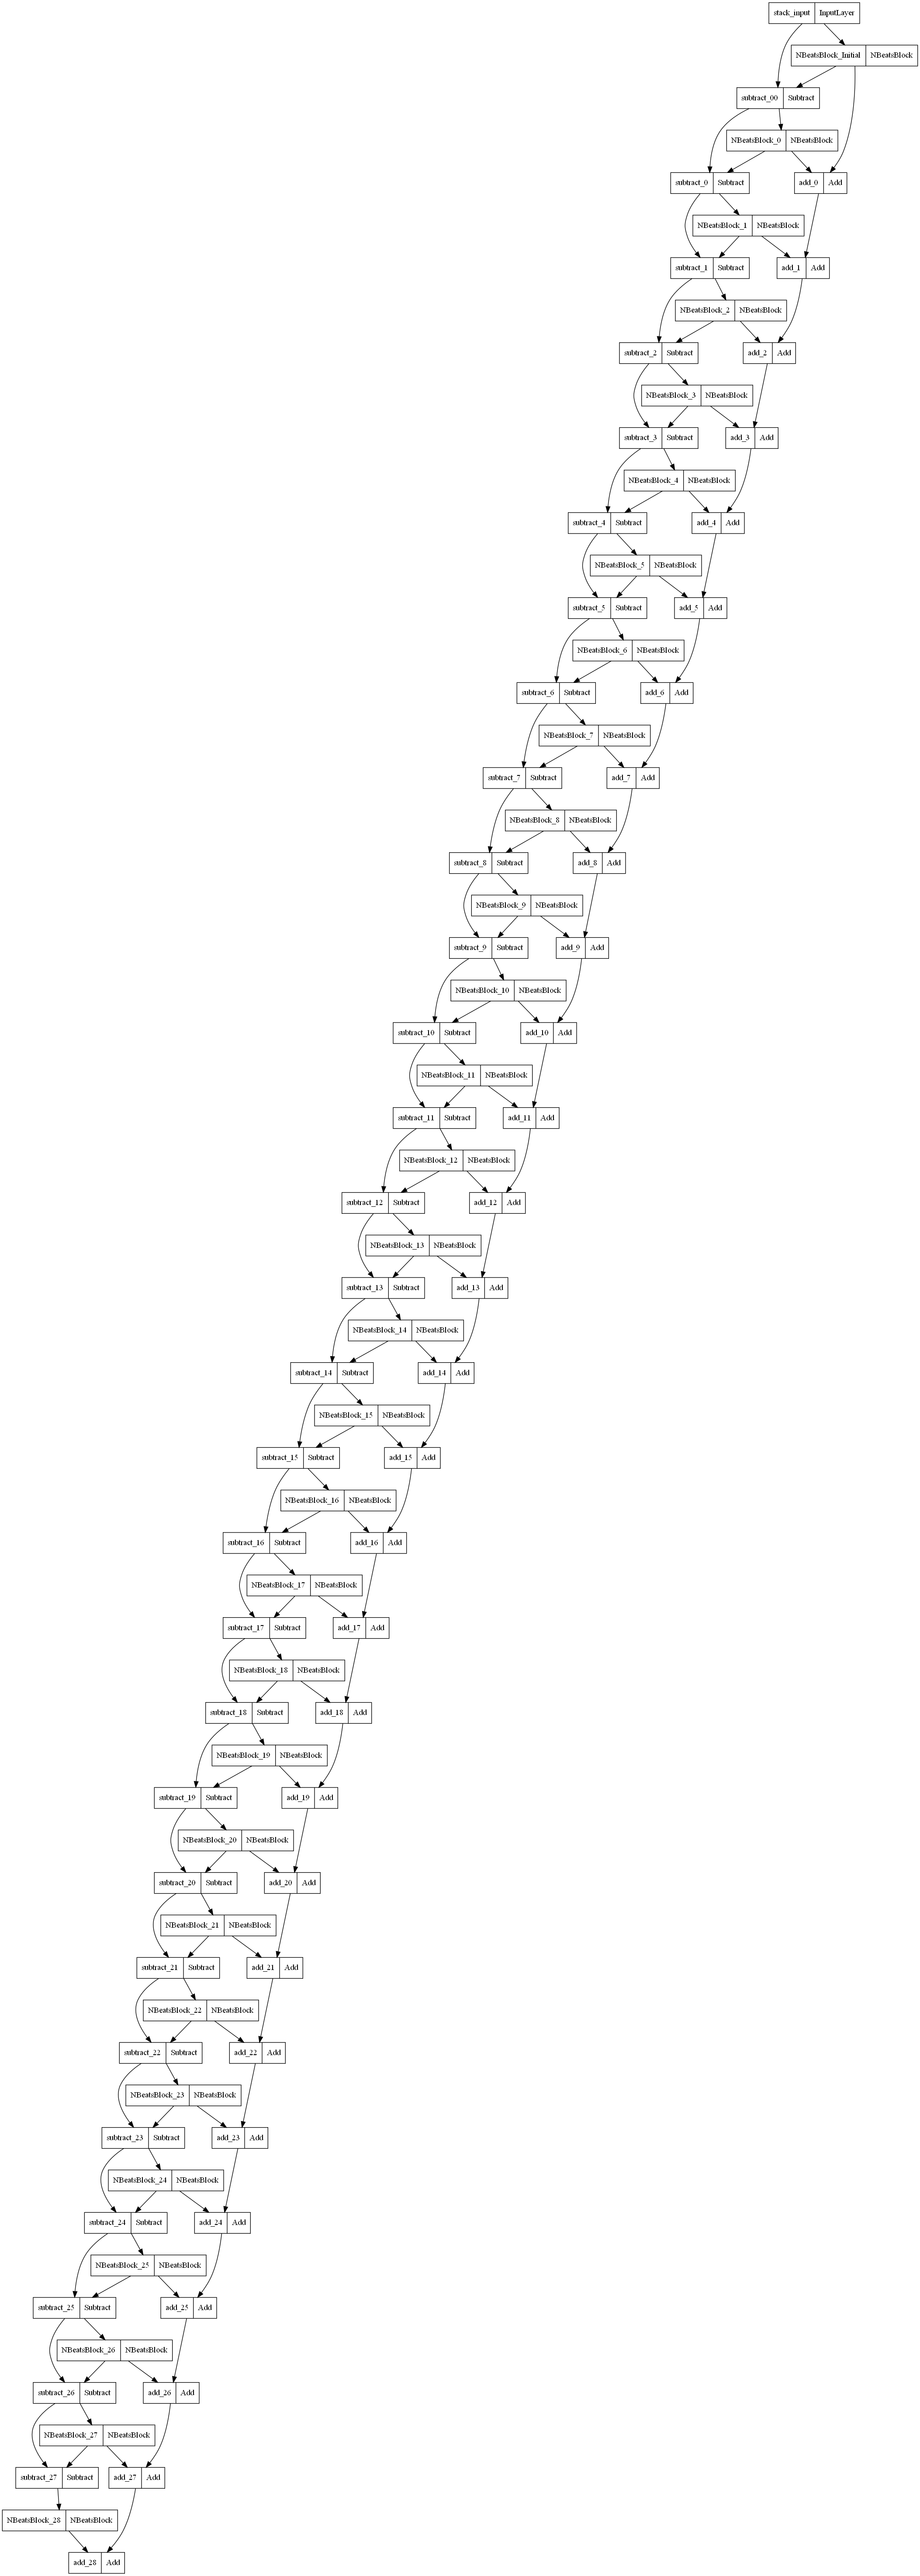

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8 - Ensemble

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iterations=10,
                        num_epochs=1000,
                        loss_functions=["mae","mse","mape"]):

    ensemble_models = []
    
    for i in range(num_iterations):
        for loss_function in loss_functions:
            print(f"Optimizing model by reducing {loss_function} for {num_epochs} epochs, model number: {i}")
            
            #Simple model
            model = tf.keras.Sequential([
                layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
                layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
                layers.Dense(HORIZON)])
            
            model.compile(loss=loss_function,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["mae","mse"])
            
            model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
            # Append fitted model to list of ensemble models
            ensemble_models.append(model)
            
    return ensemble_models

In [ ]:
%%time

ensemble_models = get_ensemble_models(num_iterations=5,
                                      num_epochs=1000)

Optimizing model by reducing mae for 1000 epochs, model number: 0

Epoch 372: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 519: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 619: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing mse for 1000 epochs, model number: 0

Epoch 386: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 486: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000 epochs, model number: 0

Epoch 172: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 275: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 375: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing mae for 1000 epochs, model number: 1

Epoch 605: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing mode

In [ ]:
ensemble_preds = helpers.get_ensemble_preds(ensemble_models=ensemble_models, data=test_dataset)
mean_ensemble_preds = tf.reduce_mean(ensemble_preds, axis=0)
median_ensemble_preds = np.median(ensemble_preds, axis=0)
mean_ensemble_preds[:5], median_ensemble_preds[:5]

1/1 [==============================] - 0s 14ms/step


(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([33705.64 , 33508.574, 34297.895, 33248.02 , 32656.824],
       dtype=float32)>,
 array([33703.53 , 33519.996, 34322.734, 33268.707, 32691.096],
       dtype=float32))

In [ ]:
mean_ensemble_results = helpers.evaluate_preds(y_true=y_test,
                                          y_pred=mean_ensemble_preds)
median_ensemble_results = helpers.evaluate_preds(y_true=y_test,
                                          y_pred=median_ensemble_preds)
mean_ensemble_results, median_ensemble_results

({'mae': 813.7552,
  'mse': 1505038.4,
  'rmse': 1226.8,
  'mape': 2.3522916,
  'mase': 1.008035},
 {'mae': 816.66614,
  'mse': 1515170.9,
  'rmse': 1230.9227,
  'mape': 2.3609605,
  'mase': 1.0116409})

In [ ]:
lower, upper = helpers.get_lower_upper_from_ensemble_preds(ensemble_preds)
lower[:5], upper[:5]

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([33378.855, 33266.445, 34097.527, 33034.723, 32339.254],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([34032.426, 33750.703, 34498.26 , 33461.316, 32974.395],
       dtype=float32)>)

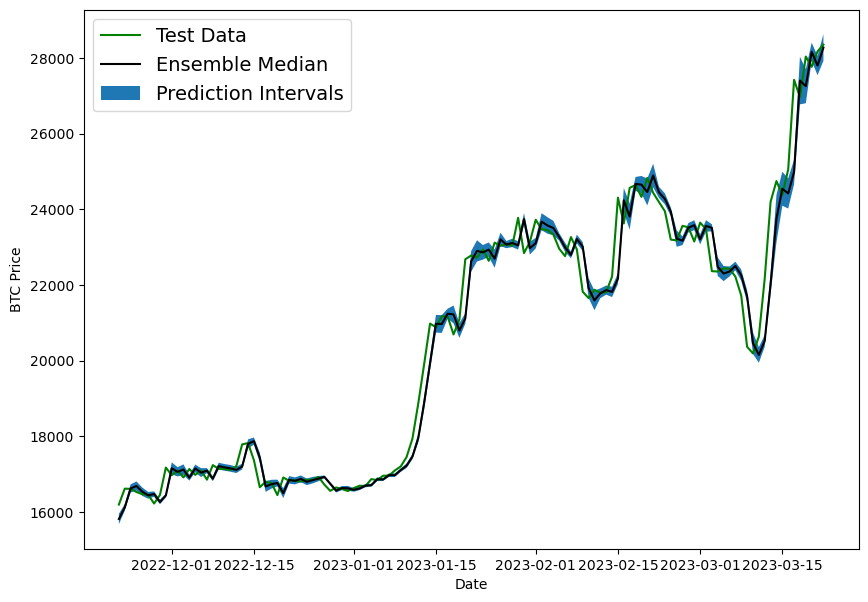

In [ ]:
offset=500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:],"g", label="Test Data")
plt.plot(X_test.index[offset:], mean_ensemble_preds[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")

plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

In [61]:
## Model 9 - Predicting into the future
HORIZON=1
WINDOW_SIZE=7
X_all = bitcoin_block_windowed_df.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
y_all = bitcoin_block_windowed_df.dropna()["Price"]
X_all[:5], y_all[:5]

(array([[435.790985, 402.152008, 398.821014, 408.903992, 394.79599 ,
         424.440002, 457.334015],
        [423.204987, 435.790985, 402.152008, 398.821014, 408.903992,
         394.79599 , 424.440002],
        [411.574005, 423.204987, 435.790985, 402.152008, 398.821014,
         408.903992, 394.79599 ],
        [404.424988, 411.574005, 423.204987, 435.790985, 402.152008,
         398.821014, 408.903992],
        [399.519989, 404.424988, 411.574005, 423.204987, 435.790985,
         402.152008, 398.821014]]),
 Date
 2014-09-24    423.204987
 2014-09-25    411.574005
 2014-09-26    404.424988
 2014-09-27    399.519989
 2014-09-28    377.181000
 Name: Price, dtype: float64)

In [62]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [64]:
tf.random.set_seed(42)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9")

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0)



In [65]:
INTO_FUTURE = 14

In [69]:
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Makes future forecasts into_future steps after values ends.
    
    Returns future forecasts as list of floats

    Args:
        values (_type_): _description_
        models (_type_): _description_
        into_future (_type_): _description_
        window_size (_type_, optional): _description_. Defaults to WINDOW_SIZE.

    Returns:
        list: list of future forecasts
    """
    
    future_forecast = []
    last_window = values[-WINDOW_SIZE:]
    
    for _ in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f'Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n')
        
        future_forecast.append(tf.squeeze(future_pred).numpy())
        print(future_forecast)
        
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
        
    return future_forecast


        
        

In [99]:
future_forecast = make_future_forecasts(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size= WINDOW_SIZE)

1/1 [==============================] - 0s 13ms/step
Predicting on:
 Date
2023-03-16    25052.789063
2023-03-17    27423.929688
2023-03-18    26965.878906
2023-03-19    28038.675781
2023-03-20    27767.236328
2023-03-21    28175.816406
2023-03-22    28354.666016
Name: Price, dtype: float64 -> Prediction: 26195.85546875

[26195.855]
1/1 [==============================] - 0s 17ms/step
Predicting on:
 [27423.929688   26965.878906   28038.675781   27767.236328
 28175.816406   28354.666016   26195.85546875] -> Prediction: 27745.822265625

[26195.855, 27745.822]
1/1 [==============================] - 0s 16ms/step
Predicting on:
 [26965.878906   28038.675781   27767.236328   28175.816406
 28354.666016   26195.85546875 27745.82226562] -> Prediction: 27601.23046875

[26195.855, 27745.822, 27601.23]
1/1 [==============================] - 0s 16ms/step
Predicting on:
 [28038.675781   27767.236328   28175.816406   28354.666016
 26195.85546875 27745.82226562 27601.23046875] -> Prediction: 28226.53710

In [71]:
future_forecast

[26195.855,
 27745.822,
 27601.23,
 28226.537,
 27961.818,
 28065.959,
 27666.008,
 27118.096,
 28039.518,
 28008.748,
 28257.3,
 27996.107,
 27950.19,
 27706.395]

In [100]:
last_timestep = bitcoin_block_windowed_df.index[-1]
start_date = last_timestep + np.timedelta64(1, "D")
end_date = start_date + np.timedelta64(INTO_FUTURE, "D")
next_timesteps = np.arange(start_date, end_date, dtype="datetime64[D]")


next_timesteps = np.insert(next_timesteps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, bitcoin_df.iloc[-1])
next_timesteps, future_forecast



(array(['2023-03-22', '2023-03-23', '2023-03-24', '2023-03-25',
        '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29',
        '2023-03-30', '2023-03-31', '2023-04-01', '2023-04-02',
        '2023-04-03', '2023-04-04', '2023-04-05'], dtype='datetime64[D]'),
 array([28354.666, 26195.855, 27745.822, 27601.23 , 28226.537, 27961.818,
        28065.959, 27666.008, 27118.096, 28039.518, 28008.748, 28257.3  ,
        27996.107, 27950.19 , 27706.395], dtype=float32))

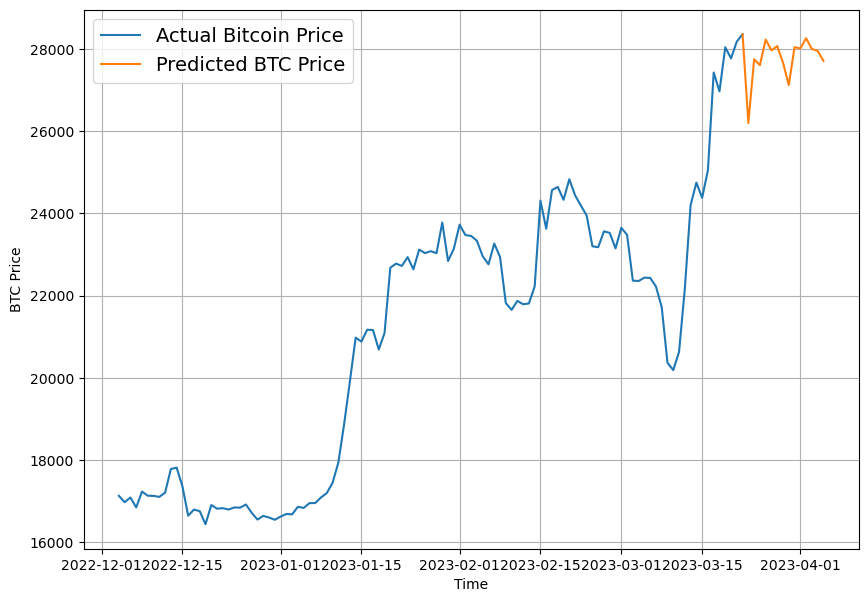

In [109]:
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_df.index, bitcoin_df["Price"], start=3000, format="-", label="Actual Bitcoin Price")
plot_time_series(next_timesteps, future_forecast, format="-", label="Predicted BTC Price")